In [5]:
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d

In [2]:
#  get gene location
def load_gene_loc():
    f = open('gene.bed', 'r')
    gene = {}
    for i in f:
        i = i.split()
        #  gene direction
        if i[5] == '+':
            gene[i[3]] = (int(i[1]), int(i[2]), 1)
        elif i[5] == '-':
            gene[i[3]] = (int(i[1]), int(i[2]), -1)
    return gene

In [3]:
def cal_distribution(filename):
    f = open(filename, 'r')
    
    #  up and down stream 100 kb
    ranges = 100000
    
    data = []
    for i in f:
        i = i.split()
        snp_loc = int(i[1])
        name = i[3]
        #  -1 < up < 0
        #  0 < gene body < 1
        #  1 < down < 2
        if (snp_loc >= gene[name][0]) and (snp_loc <= gene[name][1]):
            pos = (snp_loc-gene[name][0]+1) / (gene[name][1]-gene[name][0]+1)
        elif snp_loc < gene[name][0]:
            pos = (snp_loc-gene[name][0]+ranges+1) / ranges - 1 * gene[name][2]
        elif snp_loc > gene[name][1]:
            pos = (snp_loc-gene[name][1]) / ranges + 1 * gene[name][2]
        data.append(pos)
    f.close()

    data.sort()
    xx = -1.0
    counts = {xx: 0}
    bins = 100
    #  gene average length is 3641.48 bp from gene.bed file
    gene_len = 3641.48
    for i in data:
        if i < xx+1/bins:
            counts[round(xx,2)] += 1
        else:
            xx += 1/bins
            counts[round(xx,2)] = 1

    x, y = [], []
    for k, v in counts.items():
        x.append(k)
        if k < 0:
            #  normalize like RPKM
            y.append(v/(ranges/bins*len(data)))  #  up_stream
        elif (k >= 0) and (k < 1):
            y.append(v/(gene_len/bins*len(data)))  #  gene_body
        else:
            y.append(v/(ranges/bins*len(data)))  #  down_stream

    return x, y

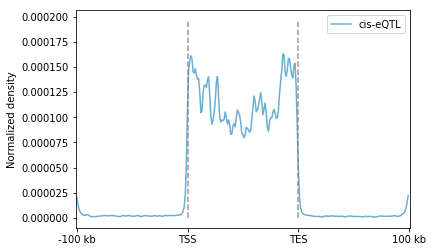

In [6]:
if __name__ == "__main__":
    gene = load_gene_loc()
    maxy = 0

    x, y = cal_distribution('All-Cis-eQTL.loc')
    y_smooth = gaussian_filter1d(y, sigma=1)
    plt.plot(x, y_smooth, label='cis-eQTL', color='#6BAED6')
    maxy = max(maxy, max(y))

    plt.plot([0,0], [0,maxy],linestyle="--", color='gray', alpha=.8)
    plt.plot([1,1], [0,maxy],linestyle="--", color='gray', alpha=.8)
    plt.xticks([-1,0,1,2], ['-100 kb', 'TSS', 'TES', '100 kb'])
    plt.xlim(-1.01, 2.01)
    plt.legend()
    plt.ylabel('Normalized density')
    # plt.savefig('result.pdf', format='pdf')